We have found that the sentiment index is a better indicator of market 'riskiness' than the volatility index is, in the sense that it gives better risk adjusted returns over the test period. We therefore want to shift our goal to predicting the sentiment one day ahead. 

To do this we start with the simplest time series models and see how they perform.

Start by loading the index and doing some time series EDA:

#### Data loading and EDA

In [3]:
# Load data and define sharpe function to evaluate the models: 
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()

r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')

#divide by 100 because it was already in % -> we dont want that here!
#then divide by 252 since its on a yearly basis but everything else is on a daily basis
#(252 ~ number of us trading days a year)
r_rf_df['rf_rate'] = r_rf_df['rf_rate']/(100*252)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
#r_rf_df.set_index('Date', inplace=True)
r_rf_df.head()

portfolio_df = pd.merge(portfolio_df, 
                        r_rf_df[['Date', 'rf_rate']], 
                        on='Date', 
                        how='inner')

sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v4_new.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.head()

portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_df, on='Date', how='inner')
portfolio_df_sent.set_index('Date', inplace=True)
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean()

#want to just look at the training period for threshold optimization
#and then just at the test period for calculating the sharpe
portfolio_df_sent_train = portfolio_df_sent[:'2018-07-01'].copy()
portfolio_df_sent_test = portfolio_df_sent['2018-07-01':].copy()

def overall_sharpe_sentiment_calc(sentiment):
    w_ndq = []
    w_rf = []
    for score in sentiment:
        if score > 21.3: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= 21.3 and score > 20: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= 20:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v4_new.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.set_index('Date', inplace=True)
sentiment_index_df.head()

,sentiment_score,sentiment_slope,lag_sentiment
Date,,,
2015-01-01,16.281544,-1.195109,NaN
2015-01-02,15.087144,-0.130807,16.281544
2015-01-03,16.691515,0.938619,15.087144
2015-01-04,16.774633,1.079692,16.691515
2015-01-05,17.779190,-1.688521,16.774633


In [6]:
#look at adf test for the original series and see if stationary:

from statsmodels.tsa.stattools import adfuller

adfuller(sentiment_index_df['sentiment_score'])

(-4.133222916990478,
 0.000853048833319256,
 19,
 1806,
 {'1%': -3.433976034843506,
  '5%': -2.8631416925158244,
  '10%': -2.5676226884667694},
 8742.580463472374)

In [7]:
adfuller(portfolio_df_sent['moving_average_10day'].dropna())

(-3.120823306353834,
 0.02505006038793159,
 22,
 1215,
 {'1%': -3.435743555099632,
  '5%': -2.8639217381867486,
  '10%': -2.568038075665972},
 743.952206467513)

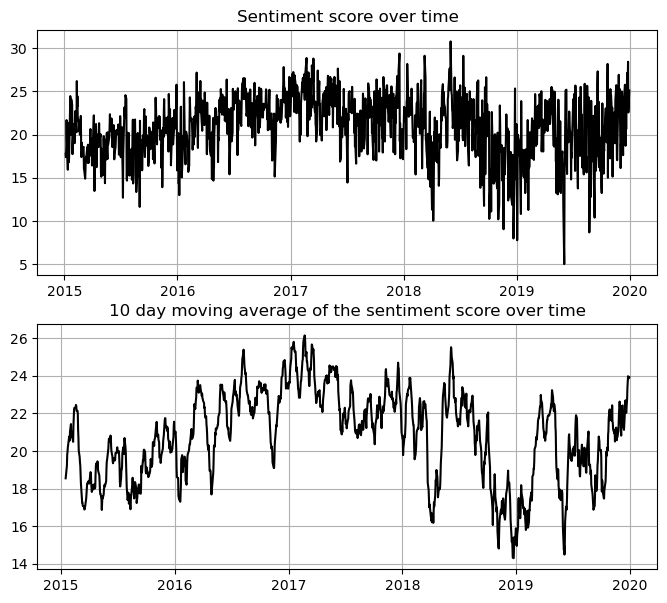

In [18]:
plt.figure(figsize=(8,7))
plt.subplot(2,1,1)
plt.title('Sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['sentiment_score'], color = 'black')
plt.subplot(2,1,2)
plt.title('10 day moving average of the sentiment score over time')
plt.grid(True)
plt.plot(portfolio_df_sent['moving_average_10day'], color = 'black')

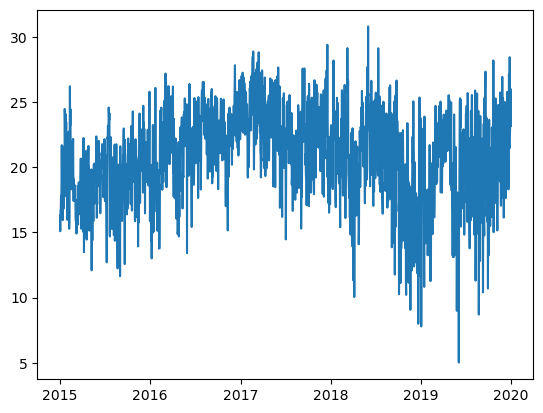

In [344]:
plt.plot(sentiment_index_df['sentiment_score'])

In [385]:
portfolio_df_sent.dropna()

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day
Date,,,,,,,,
2015-01-16,0.011741,-0.007371,19.81,1.190476e-06,17.201364,0.544563,16.805301,18.548039
2015-01-20,0.007935,0.002291,18.20,1.190476e-06,24.460571,-1.497264,18.247873,19.216177
2015-01-21,0.005117,-0.004757,17.35,1.190476e-06,23.359046,-1.541744,24.460571,19.812634
2015-01-22,0.018504,-0.002481,15.66,1.190476e-06,19.995115,0.099915,23.359046,19.954041
2015-01-23,0.002211,0.006542,15.47,7.936508e-07,24.094918,-1.615514,19.995115,20.194893
...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,6.309524e-05,27.140579,-0.659049,20.300683,22.753680
2019-12-24,0.000519,0.001724,12.36,6.269841e-05,23.723393,-2.178170,27.140579,23.362800
2019-12-26,0.008824,0.001450,12.58,6.269841e-05,28.429432,1.745469,21.436675,23.977012


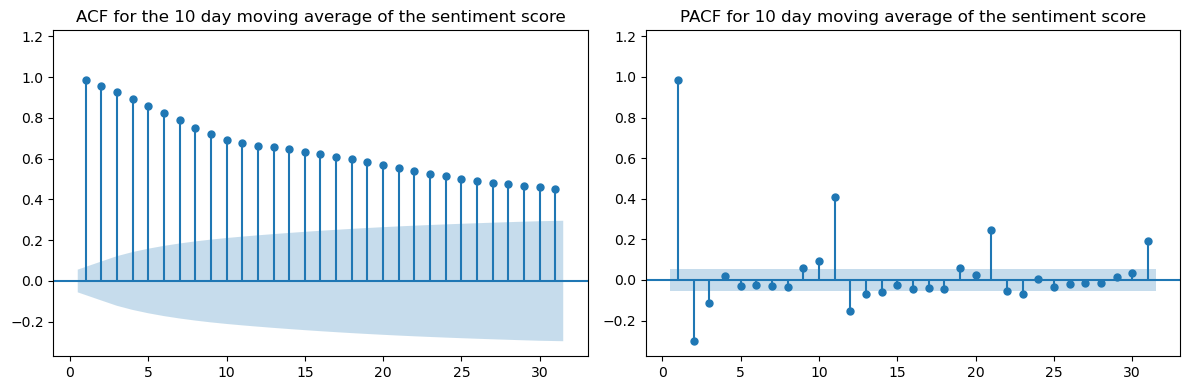

In [19]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax1, title='ACF for the 10 day moving average of the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(portfolio_df_sent['moving_average_10day'].dropna(), zero=False, auto_ylims=True, ax=ax2, title='PACF for 10 day moving average of the sentiment score')

plt.tight_layout()
plt.show()


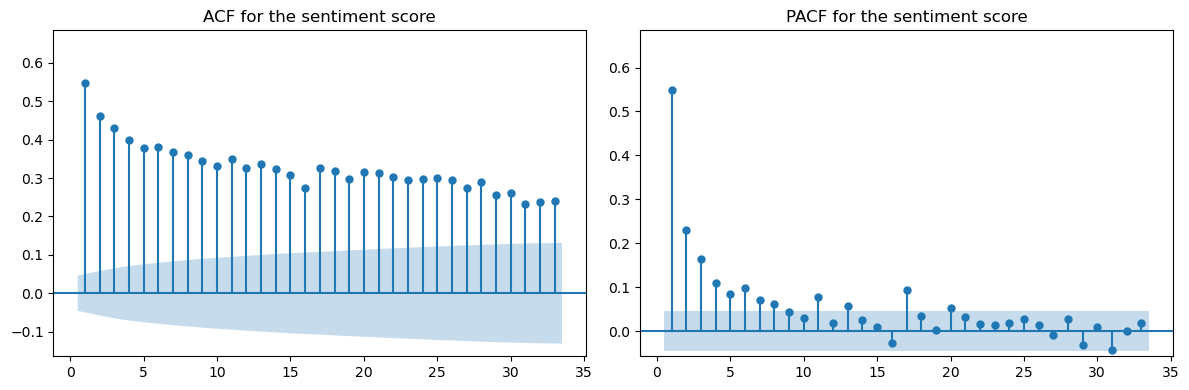

In [345]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax1, title='ACF for the sentiment score')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(sentiment_index_df['sentiment_score'], zero=False, auto_ylims=True, ax=ax2, title='PACF for the sentiment score')

plt.tight_layout()
plt.show()


See that the underlying structure isn't clear from just observing the ACF and PACF plots, we therefore instead take the more objective approach of comparing AIC and BIC scores of different model to pick the optimal number of lags. 

In [27]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 4

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(sentiment_index_df['sentiment_score'], order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (2, 2, 8853.996986993501)
Optimal lag orders based on BIC for ARMA model: (2, 1, 8884.0491508494)


Both indicate that the best model is the ARMA(2,1), so we can now fit that model to the data.
First, we need to split our data into train and test sets, where 2015-2018 is the training data and 2019 is the test data.

We then implement a rolling window forecast where we forecast the sentiment one day ahead at each step. 

In [28]:
sentiment_df_train = sentiment_index_df[:'2018-07-01'].copy()
sentiment_df_test = sentiment_index_df['2018-07-01':].copy()

In [29]:
y_train = sentiment_df_train['sentiment_score'].copy()
y_test = sentiment_df_test['sentiment_score'].copy()

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
train_data = y_train.copy() # ['sentiment_score'].copy()
test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

Overall average MSE: 0.3034583383163795


In [32]:
#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 3.398801463604458 R2: 0.2655463539265569


In [297]:
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = test_data.index

sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])

In [298]:
sharpe

0.062391011413650437

In [299]:
portfolio_df_sent_test['trading day'].sum()

121

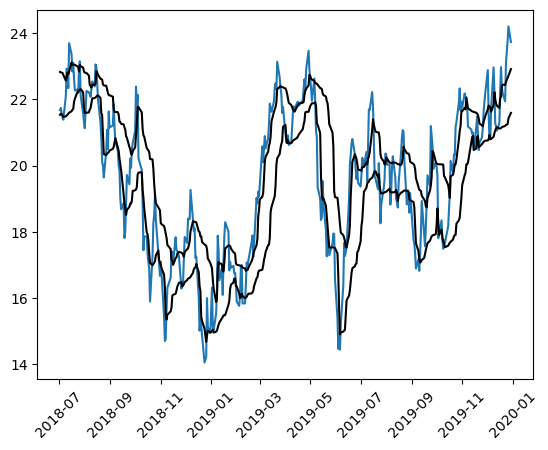

In [300]:
plt.plot(forecast_series)
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')
plt.xticks(rotation=45) 
plt.show()

In [ ]:
# #calculate RMSE and R2:
# rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
# r2 = r2_score(test_data, forecast_list)
# print("RMSE:", rmse, "R2:", r2)

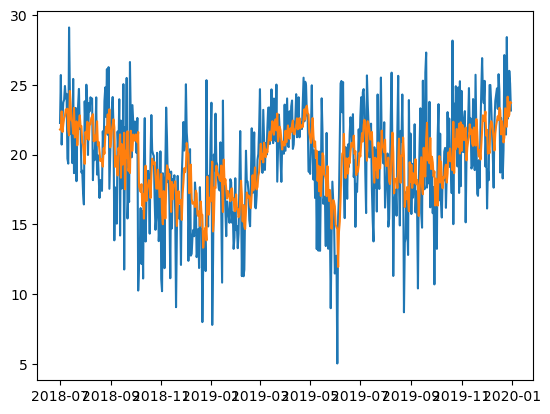

In [161]:
plt.plot(test_data)
plt.plot(test_data.index, forecast_list)
#plt.plot(portfolio_df_sent_test['moving_average_10day'])

In [34]:
pred = pd.Series(forecast_list)
pred.index = y_test.index

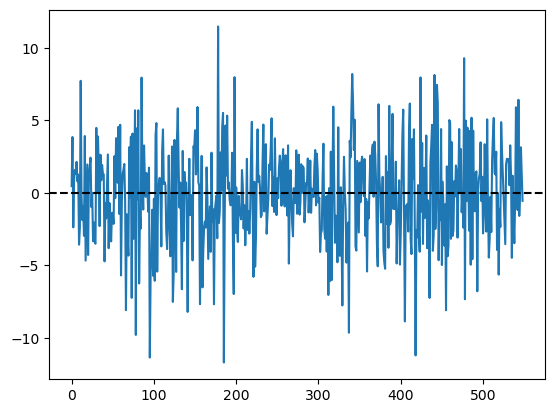

In [35]:
plt.plot(res_list)
plt.axhline(0, color = 'black', linestyle='--')

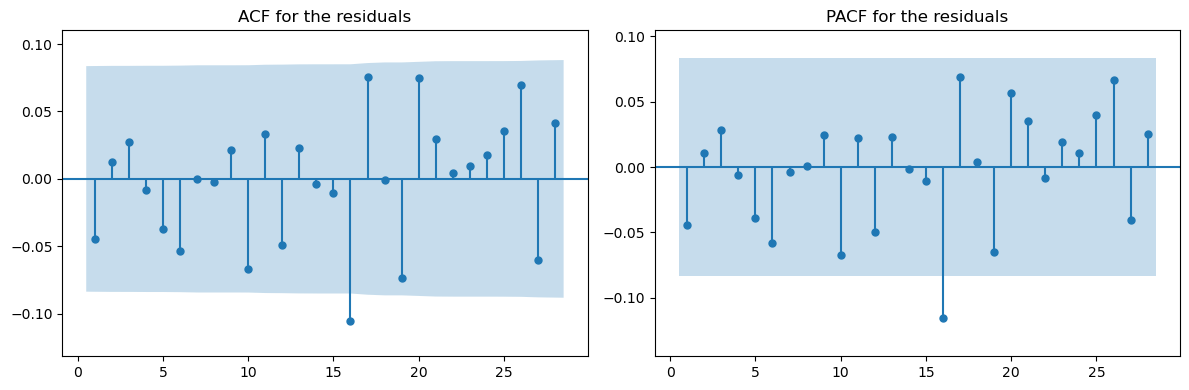

In [162]:
#Plot acf and pacf:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(np.array(res_list), zero=False, auto_ylims=True, ax=ax1, title='ACF for the residuals')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(np.array(res_list), zero=False, auto_ylims=True, ax=ax2, title='PACF for the residuals')

plt.tight_layout()
plt.show()


In [37]:
forecast_list = pd.Series(forecast_list)
forecast_list.index = y_test.index

In [38]:
overall_sharpe_sentiment_calc(forecast_list[~forecast_list.index.isin(forecast_list.index.difference(portfolio_df_sent_test.index))])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Now we can try including the slope of the sentiment index as an extra input feature for our models. For that we need to get new data:

In [39]:
sentiment_slope_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v4_new.xlsx')
sentiment_slope_df.rename(columns={'date':'Date'}, inplace=True)
#sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_slope_df.set_index('Date', inplace=True)
sentiment_slope_df.head()

,sentiment_score,sentiment_slope
Date,,
2015-01-01,16.281544,-1.195109
2015-01-02,15.087144,-0.130807
2015-01-03,16.691515,0.938619
2015-01-04,16.774633,1.079692
2015-01-05,17.779190,-1.688521


In [40]:
#check if sentiment slope is stationary:
from statsmodels.tsa.stattools import adfuller

adfuller(sentiment_slope_df['sentiment_slope'])

(-43.402514068526095,
 0.0,
 0,
 1825,
 {'1%': -3.4339382310452033,
  '5%': -2.863125003847544,
  '10%': -2.56761380228936},
 6403.128479991866)

It's stationary! So we can continue to modeling:

In [42]:
from statsmodels.tsa.api import VAR

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_var = []

max_lag = 6

# Fit VAR models with different lag orders
for p in range(0, max_lag + 1):
    model_var = VAR(sentiment_slope_df)
    results_var = model_var.fit(p)
    aic_values_var.append((p, results_var.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_var = min(aic_values_var)#, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for VAR model:", optimal_lag_aic_var)

# BIC
bic_values_var = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    model_var = VAR(sentiment_slope_df)
    results_var = model_var.fit(p)
    bic_values_var.append((p, results_var.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_var = min(bic_values_var)#, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for VAR model:", optimal_lag_bic_var)

Optimal lag orders based on AIC for VAR model: (0, 3.2129460908269776)
Optimal lag orders based on BIC for VAR model: (0, 3.2189810120330615)


Best lag is 0... so probably not appropriate to fit a var to the data.

Try machine learning models instead:

### Machine Learning

#### Tree based methods

In [163]:
# want to use lagged values of the sentiment and the slope to forecast 1 day ahead sentiment. 
# start with just one lag.

from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming 'sentiment_slope_df' is already defined and loaded
# Create lagged features
for lag in range(1, 4):  # 3 lags
    sentiment_slope_df[f'sentiment_score_lag_{lag}'] = sentiment_slope_df['sentiment_score'].shift(lag)
    sentiment_slope_df[f'sentiment_slope_lag_{lag}'] = sentiment_slope_df['sentiment_slope'].shift(lag)

# Drop rows with NaN values that were created due to lagging
sentiment_slope_df = sentiment_slope_df.dropna()

# Split the data into training and testing sets based on the year
train_df = sentiment_slope_df[sentiment_slope_df.index.year < 2019]
test_df = sentiment_slope_df[sentiment_slope_df.index.year == 2019]

# Prepare features and target variables
features = [f for f in sentiment_slope_df.columns if 'lag' in f]
X_train = train_df[features]
y_train = train_df['sentiment_score']

X_test = test_df[features]
y_test = test_df['sentiment_score']


In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [200, 205],
    'max_depth': [5, 7, 10],
    'min_samples_leaf': [5, 6, 7]
}

# Setup the grid search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

# Best Random Forest model
rf_best_model = rf_grid_search.best_estimator_


In [45]:
print(rf_best_model)

RandomForestRegressor(max_depth=5, min_samples_leaf=7, n_estimators=200,
                      random_state=42)


<BarContainer object of 6 artists>

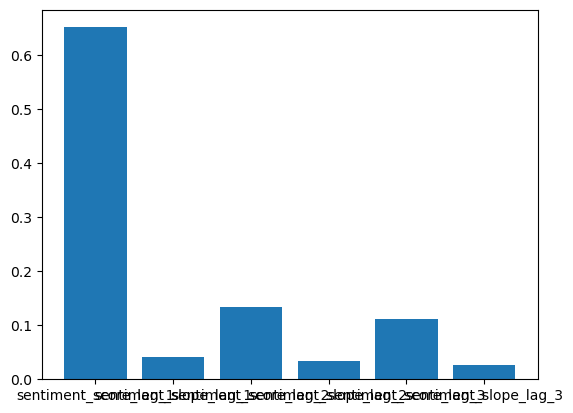

In [165]:
plt.bar(X_train.columns,rf_best_model.feature_importances_)

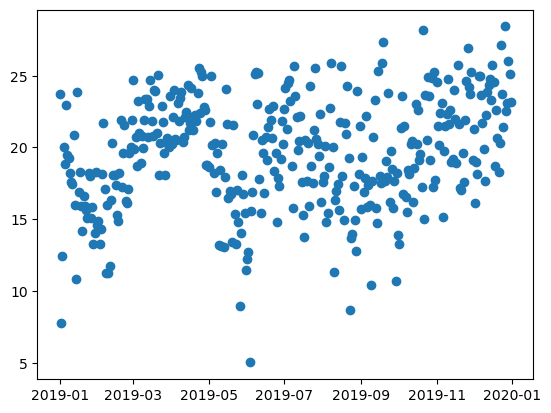

In [47]:
plt.scatter(y_test.index, y_test)

In [166]:
pred = rf_best_model.predict(X_test)
r2_score(y_test, pred)

0.18993336725057164

In [167]:
pred = pd.Series(pred)

In [168]:
pred.index = y_test.index

In [169]:
final_prediction = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

In [170]:
pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))].shape

(249,)

In [53]:
pred.index.difference(portfolio_df_sent.index)

DatetimeIndex(['2019-01-01', '2019-01-05', '2019-01-06', '2019-01-12',
               '2019-01-13', '2019-01-19', '2019-01-20', '2019-01-21',
               '2019-01-26', '2019-01-27',
               ...
               '2019-12-07', '2019-12-08', '2019-12-14', '2019-12-15',
               '2019-12-21', '2019-12-22', '2019-12-25', '2019-12-28',
               '2019-12-29', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=116, freq=None)

In [171]:
overall_sharpe_sentiment_calc(pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))])

ValueError: Length of values (249) does not match length of index (373)

using just the lag of the sentiment gives 0.1798...

In [334]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [335]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [338]:
from sklearn.metrics import mean_squared_error

# Predictions
rf_predictions = rf_best_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Evaluation using RMSE
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

#evaluation using r2:
rf_r2 = r2_score(y_test, rf_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)
print("Random Forest RMSE:", rf_rmse, "R2:", rf_r2)
print("Gradient Boosting RMSE:", gb_rmse, "R2:", gb_r2)
print("XGBoost RMSE:", xgb_rmse, "R2:", xgb_r2)

Gradient Boosting RMSE: 3.7773874359925133 R2: 0.04596733822792576
XGBoost RMSE: 3.9552186889266165 R2: -0.04597470647034729


<BarContainer object of 6 artists>

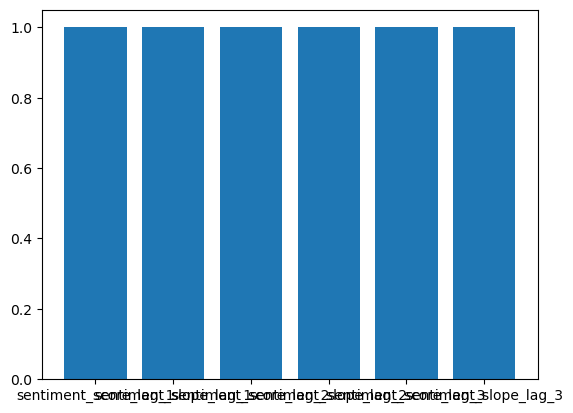

In [299]:
plt.bar(X_train.columns, rf_model.feature_importances_)

In [55]:
url1 = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/model_data_no_sentiment.csv'

df = pd.read_csv(url1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Unnamed: 0,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
Date,,,,,,,,,,,,,
2015-01-06,1254,19.05,-1.340836,66205500,-0.639069,0.75,0.353886,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886
2015-01-07,1253,17.20,1.289125,37577400,-0.639069,0.75,0.353886,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886
2015-01-08,1252,16.61,1.913960,40212600,-0.639069,0.75,0.353886,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886
2015-01-09,1251,16.60,-0.658282,41410100,-0.639069,0.75,0.353886,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886
2015-01-12,1250,17.88,-1.042701,34129800,-0.639069,0.75,0.353886,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886


In [57]:
df2 = pd.merge(sentiment_index_df, df[['Volatility_lag1']], on = 'Date', how = 'inner')

In [308]:
#df2 = pd.merge(df2, sentiment_slope_df['sentiment_slope'], on = 'Date', how = 'inner')

In [58]:
df2['slope_lag'] = df2['sentiment_slope'].shift(1)

In [59]:
df2.head()

,sentiment_score,sentiment_slope,lag_sentiment,Volatility_lag1,slope_lag
Date,,,,,
2015-01-06,17.394480,-0.425215,17.779190,18.00,NaN
2015-01-07,18.581044,-1.852799,17.394480,19.05,-0.425215
2015-01-08,21.686393,0.104260,18.581044,17.20,-1.852799
2015-01-09,19.543640,-2.596250,21.686393,16.61,0.104260
2015-01-12,15.939740,0.376702,18.854202,16.60,-2.596250


In [172]:
# Split the data into training and testing sets based on the year
train_df = df2[:'2018-07-01']
train_df.dropna(inplace=True)
test_df = df2['2018-07-01':]

# Prepare features and target variables
X_train = train_df[['lag_sentiment', 'Volatility_lag1', 'slope_lag']]
y_train = train_df['sentiment_score']

X_test = test_df[['lag_sentiment', 'Volatility_lag1', 'slope_lag']]
y_test = test_df['sentiment_score']



Epoch 1/50
14/14 [==============================] - 3s 3ms/step - loss: 224.3414
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 91.7647
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 71.8220
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 60.3864
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 56.8119
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 53.4989
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 42.8714
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 41.7165
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 36.9349
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 34.6323
Epoch 11/50
14/14 [==============================] - 0s 3ms/step - loss: 31.9188
Epoch 12/50
14/14 [==============================] - 0s 2ms/step - loss: 29.8471
Epoch 13/50
14/14 [=================

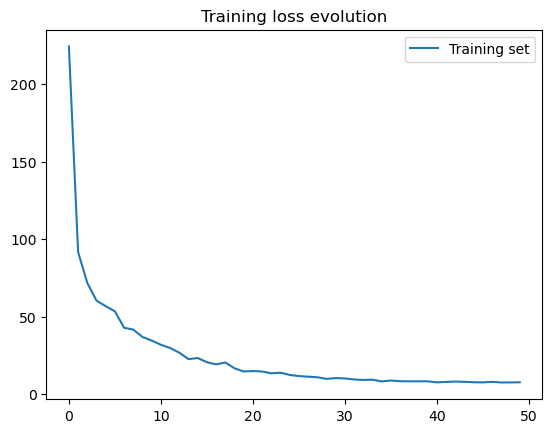

12/12 [==============================] - 0s 2ms/step
RMSE: 3.9464837217970024 R2: 0.0540351413947775


In [173]:
#Try RNN:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import keras

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(LSTM(4, return_sequences = False))
#model.add(Dense(64, activation='linear'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(8, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


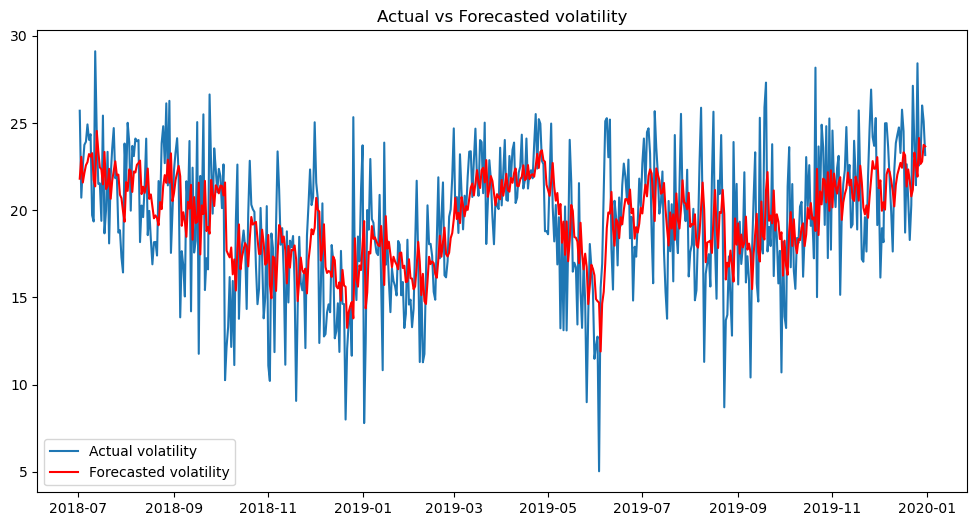

In [98]:
from statsmodels.tsa.arima.model import ARIMA
from arch.__future__ import reindexing
from arch import arch_model

volatility = sentiment_slope_df['sentiment_score']
# Set the training window size
train_size = len(sentiment_slope_df[:'2018-07-01'])

# Set forecast horizon
forecast_horizon = 1

# Initialize lists to store forecasts
mean_forecasts = []
variance_forecasts = []

for i in range(train_size, len(volatility)):
    # Training data for current window
    train_data = volatility[:i]

    # ARIMA model for mean
    arima_model = ARIMA(train_data, order=(2,0,1)) #data has ar(1) structure if we look at acf and pacf
    arima_result = arima_model.fit()
    mean_forecast = arima_result.forecast(steps=forecast_horizon)[0] # [0] to get just the value

    # GARCH model for variance
    garch_model = arch_model(train_data, vol='Garch', p=2, q=1)
    garch_result = garch_model.fit(disp='off')
    variance_forecast = garch_result.forecast(horizon=forecast_horizon).variance.values[-1, :][0]

    # Store forecasts
    mean_forecasts.append(mean_forecast)
    variance_forecasts.append(variance_forecast)

# Convert forecasts to Series for further analysis or plotting
mean_forecast_series = pd.Series(mean_forecasts, index=volatility.index[train_size:])
variance_forecast_series = pd.Series(variance_forecasts, index=volatility.index[train_size:])

# Plot the actual returns vs forecasted returns
plt.figure(figsize=(12, 6))
plt.plot(volatility.index[train_size:], volatility[train_size:], label='Actual volatility')
plt.plot(mean_forecast_series.index, mean_forecast_series, color='red', label='Forecasted volatility')
plt.legend()
plt.title('Actual vs Forecasted volatility')
plt.show()

In [127]:
r2_score(volatility[train_size:], mean_forecasts)

0.26588968117015355

In [106]:
mean_forecasts = pd.Series(mean_forecasts)
mean_forecasts.index = sentiment_slope_df['2018-07-02':].index

In [107]:
mean_forecasts

Date
2018-07-02    21.809575
2018-07-03    23.064867
2018-07-04    21.591245
2018-07-05    22.133131
2018-07-06    22.581885
                ...    
2019-12-27    24.143115
2019-12-28    22.655225
2019-12-29    22.795255
2019-12-30    23.748458
2019-12-31    23.663034
Length: 548, dtype: float64

In [110]:
portfolio_df_sent

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day
Date,,,,,,,,
2015-01-05,-0.014669,0.006101,18.00,1.190476e-06,17.779190,-1.688521,16.774633,NaN
2015-01-06,-0.013408,0.006718,19.05,1.190476e-06,17.394480,-0.425215,17.779190,NaN
2015-01-07,0.012891,-0.000186,17.20,1.190476e-06,18.581044,-1.852799,17.394480,NaN
2015-01-08,0.019140,-0.004079,16.61,1.190476e-06,21.686393,0.104260,18.581044,NaN
2015-01-09,-0.006583,0.004933,16.60,7.936508e-07,19.543640,-2.596250,21.686393,NaN
...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,6.309524e-05,27.140579,-0.659049,20.300683,22.753680
2019-12-24,0.000519,0.001724,12.36,6.269841e-05,23.723393,-2.178170,27.140579,23.362800
2019-12-26,0.008824,0.001450,12.58,6.269841e-05,28.429432,1.745469,21.436675,23.977012


In [125]:
forecasts = pd.merge(mean_forecasts.rename('forecast'), portfolio_df_sent['sentiment_score'], on ='Date', how = 'inner')

In [126]:
forecasts

,forecast,sentiment_score
Date,,
2018-07-02,21.809575,25.709066
2018-07-03,23.064867,20.722385
2018-07-05,22.133131,23.749679
2018-07-06,22.581885,23.930714
2018-07-09,23.078901,24.359113
...,...,...
2019-12-23,21.172894,27.140579
2019-12-24,23.306834,23.723393
2019-12-26,21.929082,28.429432


In [326]:
shapre, upper, lower = overall_sharpe_sentiment_prec_exp(forecasts['forecast'])

In [327]:
portfolio_df_sent_test['trading day'].sum()

177

In [328]:
shapre

0.06931628509559509

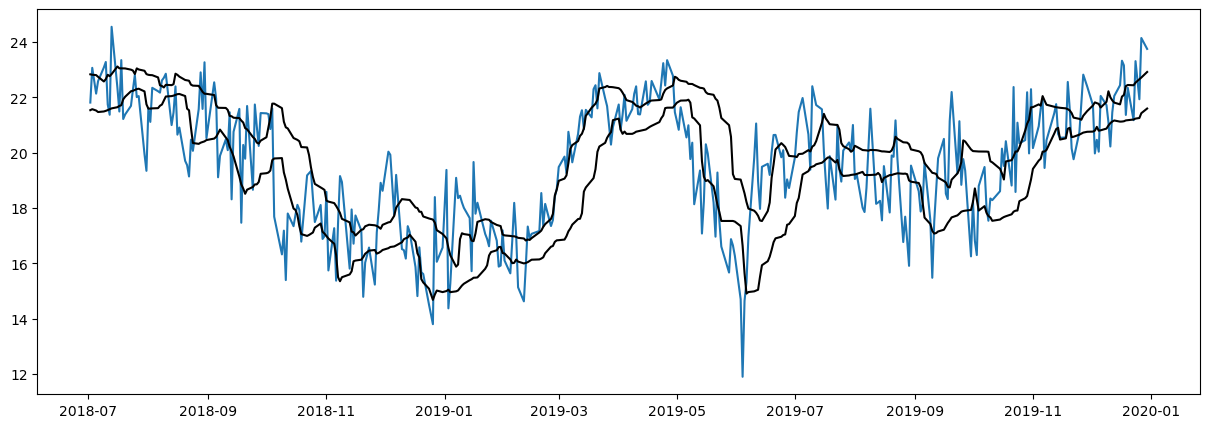

In [329]:
plt.figure(figsize=(15,5))
plt.plot(forecasts['forecast'])
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')

In [73]:
mean_forecasts

[2017-05-30    24.646049
 Freq: D, dtype: float64,
 2017-05-31    23.853848
 Freq: D, dtype: float64,
 2017-06-01    22.85916
 Freq: D, dtype: float64,
 2017-06-02    23.286371
 Freq: D, dtype: float64,
 2017-06-03    24.861301
 Freq: D, dtype: float64,
 2017-06-04    24.408137
 Freq: D, dtype: float64,
 2017-06-05    23.230174
 Freq: D, dtype: float64,
 2017-06-06    23.690291
 Freq: D, dtype: float64,
 2017-06-07    23.343818
 Freq: D, dtype: float64,
 2017-06-08    22.626376
 Freq: D, dtype: float64,
 2017-06-09    24.261158
 Freq: D, dtype: float64,
 2017-06-10    21.241555
 Freq: D, dtype: float64,
 2017-06-11    21.578721
 Freq: D, dtype: float64,
 2017-06-12    21.464275
 Freq: D, dtype: float64,
 2017-06-13    20.394028
 Freq: D, dtype: float64,
 2017-06-14    21.677018
 Freq: D, dtype: float64,
 2017-06-15    21.725826
 Freq: D, dtype: float64,
 2017-06-16    20.986954
 Freq: D, dtype: float64,
 2017-06-17    20.802073
 Freq: D, dtype: float64,
 2017-06-18    20.471495
 Freq: 

In [174]:
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,103.760002,104.199997,102.440002,102.940002,95.704712,31314600
2015-01-05,102.489998,102.610001,101.139999,101.430000,94.300850,36521300
2015-01-06,101.580002,101.750000,99.620003,100.070000,93.036430,66205500
2015-01-07,100.730003,101.599998,100.489998,101.360001,94.235786,37577400
2015-01-08,102.220001,103.500000,102.110001,103.300003,96.039421,40212600


In [175]:
df2 = pd.merge(df2, price_df['Adj Close'], on = 'Date', how = 'inner')

In [176]:
# Split the data into training and testing sets based on the year
train_df = df2[df2.index.year < 2019]
train_df.dropna(inplace=True)
test_df = df2[df2.index.year == 2019]

# Prepare features and target variables
X_train = train_df[['lag_sentiment', 'Volatility_lag1', 'slope_lag', 'Adj Close']]
y_train = train_df['sentiment_score']

X_test = test_df[['lag_sentiment', 'Volatility_lag1', 'slope_lag', 'Adj Close']]
y_test = test_df['sentiment_score']



-----------------------------------------------------------------------------

In [177]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Step 1: Fit an ARIMA model
# Assume `time_series` is your time series data
arima_model = ARIMA(y_train, order=(2,0,1))
arima_result = arima_model.fit()

# Step 2: Compute residuals
arima_residuals = y_train - arima_result.fittedvalues

# Step 3: Train a machine learning model on the residuals
# For this example, we'll use a lag of 1 for simplicity
X = arima_residuals.shift(1).dropna()
y = arima_residuals[1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.values.reshape(-1, 1), y_train)

# Step 4: Use the ARIMA model to forecast and then adjust using the ML model
arima_forecast = arima_result.forecast(steps=1)
ml_adjustment = rf_model.predict(np.array(arima_forecast - arima_result.fittedvalues.iloc[-1]).reshape(-1, 1))

# The final forecast is the combination of the ARIMA forecast and the ML adjustment
final_forecast = arima_forecast + ml_adjustment

# `final_forecast` is your hybrid model forecast


In [178]:
final_forecast

1003    18.934332
dtype: float64

In [324]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming you have a pandas DataFrame `df` with your time series data in a column named 'value'

# Data preprocessing
# Scale data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df2['sentiment_score'].values.reshape(-1, 1))

# Create a dataset where X is the number of past days you want to use to predict the future
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30 # number of past days you want to use to predict the future
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

# Predicting and inverse transforming the scaled data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse-scaling to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Use `test_predict` for evaluation and plotting your predictions


Epoch 1/20
62/62 [==============================] - 4s 15ms/step - loss: 0.0513
Epoch 2/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0230
Epoch 3/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0192
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0162
Epoch 5/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0152
Epoch 6/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0142
Epoch 7/20
62/62 [==============================] - 1s 17ms/step - loss: 0.0141
Epoch 8/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0127
Epoch 9/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0130
Epoch 10/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0127
Epoch 11/20
62/62 [==============================] - 1s 15ms/step - loss: 0.0125
Epoch 12/20
62/62 [==============================] - 1s 16ms/step - loss: 0.0126
Epoch 13/20
62/62 [==================

In [325]:
from sklearn.metrics import mean_squared_error, r2_score

# Assume `y_test` are the true values and `test_predict` are the model's predictions
# Note: `y_test` and `test_predict` should be in the original scale (if scaling was applied)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'RMSE: {rmse}')

# Calculate R²
r2 = r2_score(y_test, test_predict)
print(f'R²: {r2}')


RMSE: 20.360240414521222
R²: -19116.12220691253


------------------------------------------------------
Modeling with the 10 day moving average

In [181]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Ignore all warnings
warnings.filterwarnings("ignore")

# Determine optimal lag value with AIC and BIC for ARMA

# AIC
aic_values_arma = []

max_lag = 4

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))  # (p, d, q) for ARMA model
        results_arma = model_arma.fit()
        aic_values_arma.append((p, q, results_arma.aic))

# Find the lag orders with the lowest AIC
optimal_lag_aic_arma = min(aic_values_arma, key=lambda x: x[2])  # Minimum AIC tuple
print("Optimal lag orders based on AIC for ARMA model:", optimal_lag_aic_arma)

# BIC
bic_values_arma = []

# Fit ARMA models with different lag orders
for p in range(0, max_lag + 1):
    for q in range(0, max_lag + 1):
        model_arma = ARIMA(portfolio_df_sent['moving_average_10day'].dropna(), order=(p, 0, q))
        results_arma = model_arma.fit()
        bic_values_arma.append((p, q, results_arma.bic))

# Find the lag orders with the lowest BIC
optimal_lag_bic_arma = min(bic_values_arma, key=lambda x: x[2])  # Minimum BIC tuple
print("Optimal lag orders based on BIC for ARMA model:", optimal_lag_bic_arma)

Optimal lag orders based on AIC for ARMA model: (3, 4, 1071.383092297266)
Optimal lag orders based on BIC for ARMA model: (3, 4, 1117.474364376467)


In [182]:

# Rolling window (window size is 80% of data)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


# Initialize lists to store MSE values and forecasts
res_list = []
forecast_list = []
conf = []

#initial training and test sets:
#train_data = y_train.copy() # ['sentiment_score'].copy()
#test_data = y_test.copy() #sentiment_df_test['sentiment_score'].copy()
train_data = portfolio_df_sent[:'2018-07-01']['moving_average_10day'].dropna().copy()
test_data = portfolio_df_sent['2018-07-01':]['moving_average_10day'].copy()

for i in test_data.index:
    #print(len(train_data))
    # model = AutoReg(train_data, lags=optimal_lag_bic) # optimal lag = 10
    model = ARIMA(train_data, order=(3, 0, 4))
    model_fit = model.fit()

    #forecast = model_fit.predict(start=len(train_data), end=len(train_data))
    # forecast = model_fit.forecast(steps=1)
    get_forecast = model_fit.get_forecast(steps=1)

    forecast = get_forecast.predicted_mean
    forecast_conf = get_forecast.conf_int(alpha=0.05)

    #print(len(forecast))

    #print(forecast)
    forecast_list.append(forecast)
    conf.append(forecast_conf)

    #print(test_data[i])

    res = test_data[i] - forecast
    res_list.append(res)

    # Expand estimation window
    test_to_train = pd.Series([test_data[i]], index=[i])
    #print(test_to_train)
    train_data = pd.concat([train_data, test_to_train])
    train_data = train_data.iloc[1:]
    #print(len(train_data))


    #print(train_data[-5:])

# Calculate the overall average MSE
mse = np.mean(np.square(res))
print("Overall average MSE:", mse)

Overall average MSE: 0.03706717893845573


In [183]:
#calculate RMSE and R2:
rmse = np.sqrt(mean_squared_error(test_data, forecast_list))
r2 = r2_score(test_data, forecast_list)
print("RMSE:", rmse, "R2:", r2)

RMSE: 0.4689340645311972 R2: 0.9576028000237256


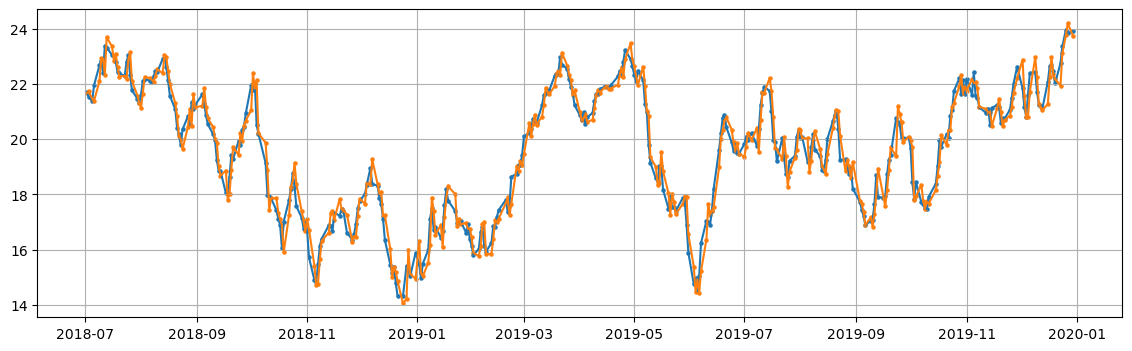

In [354]:
plt.figure(figsize=(14,4))
plt.plot(test_data)
plt.scatter(test_data.index, test_data, s = 5)
plt.plot(test_data.index, forecast_list)
plt.scatter(test_data.index, forecast_list, s = 5)
plt.grid(True)

In [185]:
# Extract numeric values from each Series in the list
values = [s.iloc[0] for s in forecast_list]  # `s.iloc[0]` accesses the first value in each Series

In [186]:

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = test_data.index

In [330]:
sharpe, upper, lower = overall_sharpe_sentiment_prec_exp(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])

In [331]:
sharpe

0.062391011413650437

In [302]:
overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['moving_average_10day'])[0]

0.14001041657537563

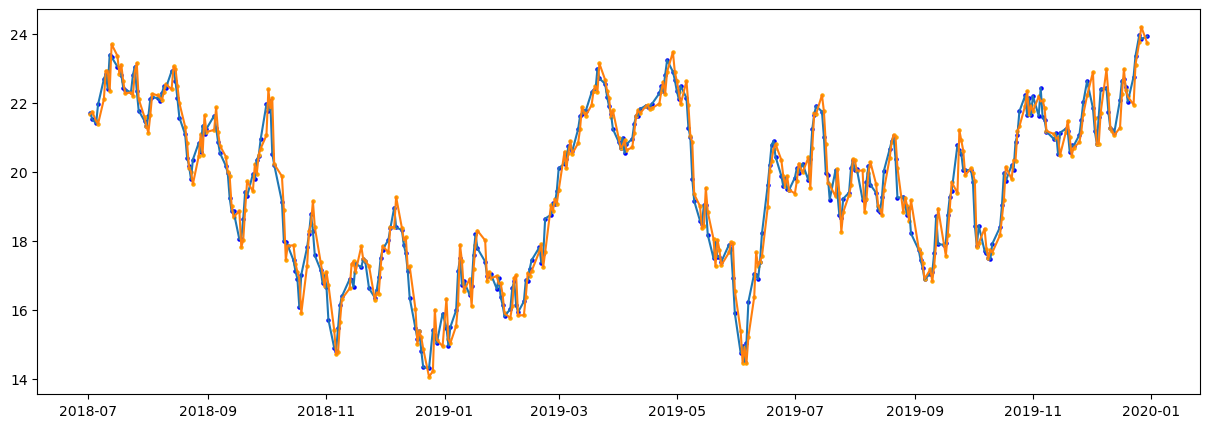

In [313]:
plt.figure(figsize=(15,5))
plt.plot(portfolio_df_sent_test['moving_average_10day'])
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['moving_average_10day'], s = 5, color = 'blue')
plt.plot(forecast_series)
plt.scatter(portfolio_df_sent_test.index, forecast_series, s = 5, color = 'orange')
#plt.plot(upper['2018-07-01':], color = 'black')
#plt.plot(lower['2018-07-01':], color = 'black')

In [314]:
mean_squared_error(portfolio_df_sent_test['moving_average_10day'], forecast_series)

0.219899156877749

In [315]:
r2_score(portfolio_df_sent_test['moving_average_10day'], forecast_series)

0.9576028000237256

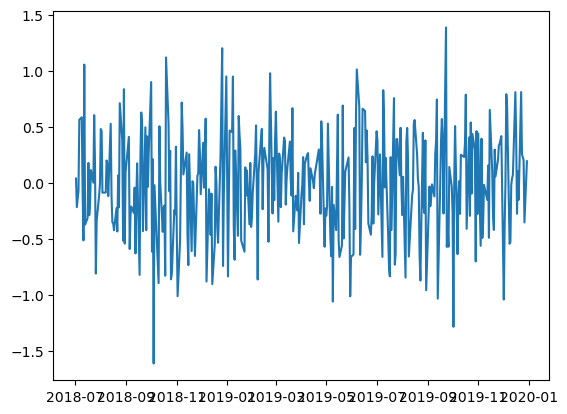

In [316]:
plt.plot(portfolio_df_sent_test['moving_average_10day'] - forecast_series)

In [201]:
residuals = portfolio_df_sent_test['moving_average_10day'] - forecast_series

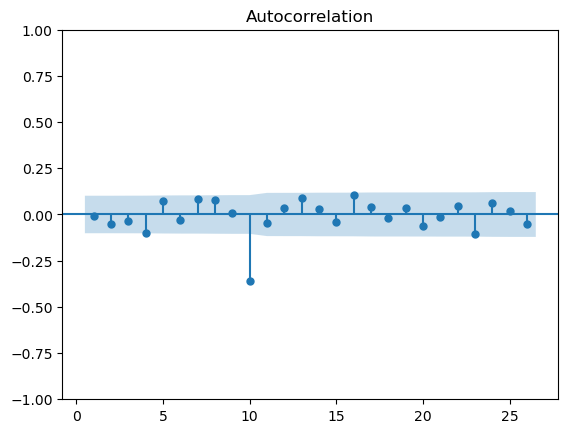

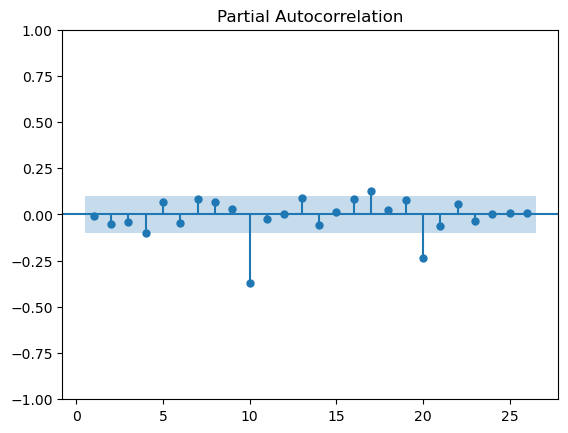

In [202]:
plot_acf(residuals, zero=False)
plt.show()
plot_pacf(residuals, zero=False)
plt.show()

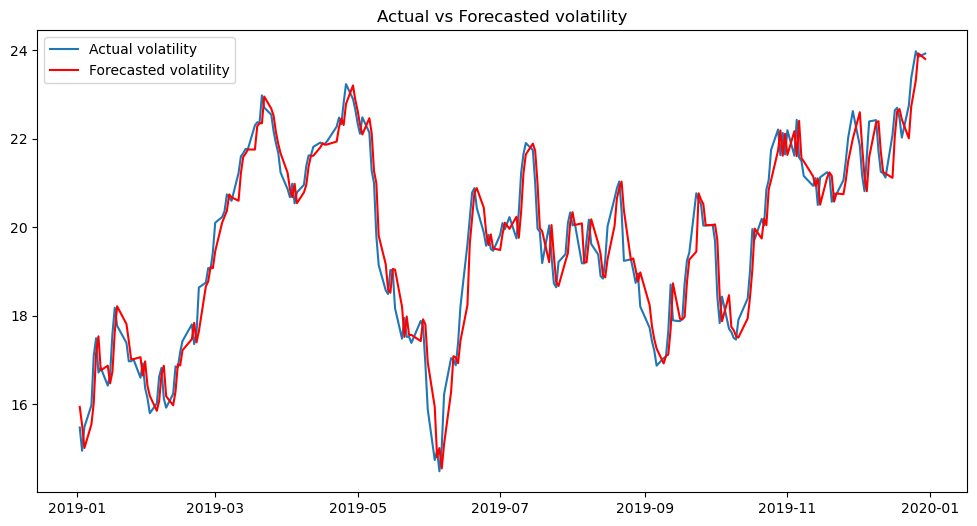

In [446]:
from statsmodels.tsa.arima.model import ARIMA
from arch.__future__ import reindexing
from arch import arch_model

volatility = portfolio_df_sent['moving_average_10day'].dropna()
# Set the training window size
train_size = len(portfolio_df_sent_train['moving_average_10day'].dropna())

# Set forecast horizon
forecast_horizon = 1

# Initialize lists to store forecasts
mean_forecasts = []
variance_forecasts = []

for i in range(train_size, len(volatility)):
    # Training data for current window
    train_data = volatility[:i]

    # ARIMA model for mean
    arima_model = ARIMA(train_data, order=(3,0,4)) #data has ar(1) structure if we look at acf and pacf
    arima_result = arima_model.fit()
    mean_forecast = arima_result.forecast(steps=forecast_horizon)

    # GARCH model for variance
    garch_model = arch_model(train_data, vol='Garch', p=3, q=4)
    garch_result = garch_model.fit(disp='off')
    variance_forecast = garch_result.forecast(horizon=forecast_horizon).variance.values[-1, :][0]

    # Store forecasts
    mean_forecasts.append(mean_forecast)
    variance_forecasts.append(variance_forecast)

# Convert forecasts to Series for further analysis or plotting
mean_forecast_series = pd.Series(mean_forecasts, index=volatility.index[train_size:])
variance_forecast_series = pd.Series(variance_forecasts, index=volatility.index[train_size:])

# Plot the actual returns vs forecasted returns
plt.figure(figsize=(12, 6))
plt.plot(volatility.index[train_size:], volatility[train_size:], label='Actual volatility')
plt.plot(mean_forecast_series.index, mean_forecast_series, color='red', label='Forecasted volatility')
plt.legend()
plt.title('Actual vs Forecasted volatility')
plt.show()

In [447]:
r2_score(volatility[train_size:], mean_forecasts)

0.9428213419952607

In [332]:
# Extract numeric values from each Series in the list
values = [s.iloc[0] for s in mean_forecasts]  # `s.iloc[0]` accesses the first value in each Series

# Create a new Series from the list of values
forecast_series = pd.Series(values)
forecast_series.index = test_data.index

AttributeError: 'float' object has no attribute 'iloc'

In [454]:
overall_sharpe_sentiment_calc(forecast_series[~forecast_series.index.isin(forecast_series.index.difference(portfolio_df_sent_test.index))])

0.1235740121826953

exactly the same sharpe as using the lag moving average....

In [457]:
portfolio_df_sent

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day
Date,,,,,,,,
2015-01-05,-0.014669,0.006101,18.00,1.190476e-06,17.779190,-1.688521,16.774633,NaN
2015-01-06,-0.013408,0.006718,19.05,1.190476e-06,17.394480,-0.425215,17.779190,NaN
2015-01-07,0.012891,-0.000186,17.20,1.190476e-06,18.581044,-1.852799,17.394480,NaN
2015-01-08,0.019140,-0.004079,16.61,1.190476e-06,21.686393,0.104260,18.581044,NaN
2015-01-09,-0.006583,0.004933,16.60,7.936508e-07,19.543640,-2.596250,21.686393,NaN
...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,6.309524e-05,27.140579,-0.659049,20.300683,22.753680
2019-12-24,0.000519,0.001724,12.36,6.269841e-05,23.723393,-2.178170,27.140579,23.362800
2019-12-26,0.008824,0.001450,12.58,6.269841e-05,28.429432,1.745469,21.436675,23.977012


In [203]:
portfolio_df_sent.columns

Index(['r_ndq', 'r_rf', 'Volatility', 'rf_rate', 'sentiment_score',
       'sentiment_slope', 'lag_sentiment', 'moving_average_10day'],
      dtype='object')

In [204]:
# try random forest, gradient boosting and xgboost:
# for that we need the lags of the moving average:

moving_average_df = portfolio_df_sent.copy().dropna()
moving_average_df['moving_average_10day_lag'] = moving_average_df['moving_average_10day'].shift(1)
moving_average_df['volatility_lag'] = moving_average_df['Volatility'].shift(1)
moving_average_df['r_ndq_lag'] = moving_average_df['r_ndq'].shift(1)
moving_average_df['slope_lag'] = moving_average_df['sentiment_slope'].shift(1)
moving_average_df = moving_average_df.dropna()

X_train_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag' ]][:'2018-07-01']
X_test_ma = moving_average_df[['moving_average_10day_lag', 'volatility_lag', 'r_ndq_lag', 'slope_lag']]['2018-07-01':]
y_train_ma = moving_average_df['moving_average_10day'][:'2018-07-01']
y_test_ma = moving_average_df['moving_average_10day']['2018-07-01':]

In [205]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
# new y_train : train_residuals, new y_test : test_residuals

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
    #"XGBoost": xgb.XGBRegressor(random_state = 42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(25,40), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(20,30), 'learning_rate': np.linspace(0.2,0.5,7), 'max_depth': [1,3,4]}
    #"XGBoost": {'n_estimators': range(5,15), 'learning_rate': }
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = GridSearchCV(estimator=model, param_grid=params, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
    param_search.fit(X_train_ma, y_train_ma)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_ma)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test_ma, y_pred))
    r2 = r2_score(y_test_ma, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance

print(model_performance)

Model:   Random Forest
{'n_estimators': range(25, 40), 'max_depth': range(1, 5)}


RandomForestRegressor(max_depth=4, n_estimators=38, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(20, 30), 'learning_rate': array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]), 'max_depth': [1, 3, 4]}
GradientBoostingRegressor(learning_rate=0.35, n_estimators=20, random_state=42)
{'Random Forest': {'RMSE': 0.6343326910227107, 'R2': 0.9224203530320662, 'Best Params': {'max_depth': 4, 'n_estimators': 38}}, 'Gradient Boosting': {'RMSE': 0.647660604241094, 'R2': 0.9191260653566966, 'Best Params': {'learning_rate': 0.35, 'max_depth': 3, 'n_estimators': 20}}}


In [333]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [150, 200, 225, 250],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 6, 7]
}

# Setup the grid search
rf_grid_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_ma, y_train_ma)

# Best Random Forest model
rf_best_model = rf_grid_search.best_estimator_

pred = rf_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

0.9255511002552824


In [335]:
overall_sharpe_sentiment_prec_exp(final_prediction)[0]

0.05393112945258142

In [262]:
rf_best_model.feature_importances_

array([0.99550084, 0.00119146, 0.00202032, 0.00128738])

In [264]:
rf_best_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=150,
                      random_state=42)>

In [271]:
X_train_rolling.shape

(865, 4)

In [274]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf' : 5}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 1, 'learning_rate': 0.1111111111111111}
}

# Assuming y_test, X_train2, X_test2, y_train are defined somewhere here

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 864

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test_ma.copy()
    #print(actuals.head())

    # Start rolling window forecast
    for i in range(len(X_test_ma)):
        #start and end of rolling window:
        start_point = max(0, len(X_train_ma) + i - window_size)
        end_point = len(X_train_ma) + i
        #print(start_point, end_point)

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_ma).iloc[i:], pd.DataFrame(X_test_ma).iloc[:i]])
        y_train_rolling = pd.concat([y_train_ma, y_test_ma.iloc[:i]]).iloc[start_point:end_point]
        #print(X_train_rolling.shape)

        # Scale x train:
        scaler = StandardScaler()
        X_train_rolling_scaled = scaler.fit_transform(X_train_rolling)
        X_train_rolling_scaled_df = pd.DataFrame(X_train_rolling_scaled, columns = X_train_rolling.columns)
        model.set_params(**params)
        model.fit(X_train_rolling_scaled_df, y_train_rolling)
        
        # Scale x test for the current point:
        X_test_scaled = scaler.transform(X_test_ma.iloc[[i]])
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test_ma.columns)
    
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test_scaled_df)
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
0 864
(864, 4)


1 865
(864, 4)
2 866
(864, 4)
3 867
(864, 4)
4 868
(864, 4)
5 869
(864, 4)
6 870
(864, 4)
7 871
(864, 4)
8 872
(864, 4)
9 873
(864, 4)
10 874
(864, 4)
11 875
(864, 4)
12 876
(864, 4)
13 877
(864, 4)
14 878
(864, 4)
15 879
(864, 4)
16 880
(864, 4)
17 881
(864, 4)
18 882
(864, 4)
19 883
(864, 4)
20 884
(864, 4)
21 885
(864, 4)
22 886
(864, 4)
23 887
(864, 4)
24 888
(864, 4)
25 889
(864, 4)
26 890
(864, 4)
27 891
(864, 4)
28 892
(864, 4)
29 893
(864, 4)
30 894
(864, 4)
31 895
(864, 4)
32 896
(864, 4)
33 897
(864, 4)
34 898
(864, 4)
35 899
(864, 4)
36 900
(864, 4)
37 901
(864, 4)
38 902
(864, 4)
39 903
(864, 4)
40 904
(864, 4)
41 905
(864, 4)
42 906
(864, 4)
43 907
(864, 4)
44 908
(864, 4)
45 909
(864, 4)
46 910
(864, 4)
47 911
(864, 4)
48 912
(864, 4)
49 913
(864, 4)
50 914
(864, 4)
51 915
(864, 4)
52 916
(864, 4)
53 917
(864, 4)
54 918
(864, 4)
55 919
(864, 4)
56 920
(864, 4)
57 921
(864, 4)
58 922
(864, 4)
59 923
(864, 4)
60 924
(864, 4)
61 925
(864, 4)
62 926
(864, 4)
63 927
(864, 4)
6

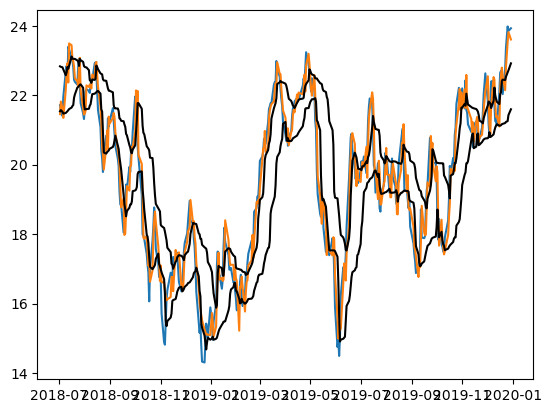

In [348]:
plt.plot(portfolio_df_sent_test['moving_average_10day'])
plt.plot(portfolio_df_sent_test.index, model_predictions2['Random Forest']['y_pred'])
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')

In [284]:
rf_pred =  model_predictions2['Random Forest']['y_pred']
rf_pred = pd.Series(rf_pred)
rf_pred.index = portfolio_df_sent_test.index

In [346]:
overall_sharpe_sentiment_prec_exp(rf_pred)[0]

0.05646672374326204

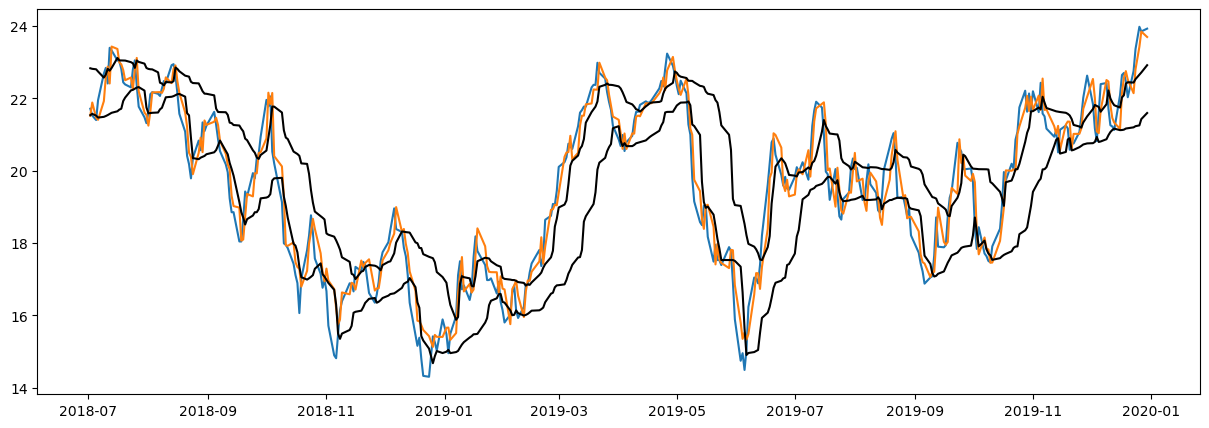

In [324]:
plt.figure(figsize=(15,5))
plt.plot(portfolio_df_sent_test['moving_average_10day'])
plt.plot(portfolio_df_sent_test.index, predictions)
plt.plot(upper['2018-07-01':], color = 'black')
plt.plot(lower['2018-07-01':], color = 'black')

In [319]:
gb_pred =  model_predictions2['Gradient Boosting']['y_pred']
gb_pred = pd.Series(gb_pred)
gb_pred.index = portfolio_df_sent_test.index

In [321]:
overall_sharpe_sentiment_prec_exp(gb_pred)[0]

0.052054685266872215

In [325]:
overall_sharpe_sentiment_precentiles(gb_pred)[0]

0.07424322431178275

<BarContainer object of 4 artists>

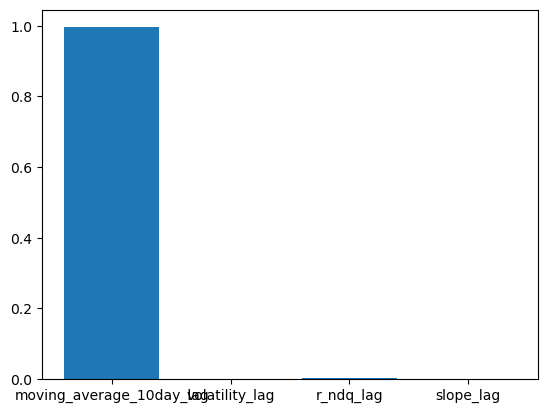

In [263]:
plt.bar(X_train_ma.columns, rf_best_model.feature_importances_)

In [209]:
overall_sharpe_sentiment_calc(final_prediction)

0.11395103638016794

In [221]:
overall_sharpe_sentiment_calc(forecast_series)

0.09577475025334001

In [339]:
overall_sharpe_sentiment_precentiles(forecast_series)[0]

0.07916726762775568

In [217]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_10day'])

0.16002022423460588

In [340]:
overall_sharpe_sentiment_prec_exp(portfolio_df_sent_test['moving_average_10day'])[0]

0.14001041657537563

In [342]:
overall_sharpe_sentiment_precentiles(final_prediction)[0]

0.08445538977333947

In [223]:
overall_sharpe_sentiment_prec_exp(final_prediction)[0]

0.08584025473028456

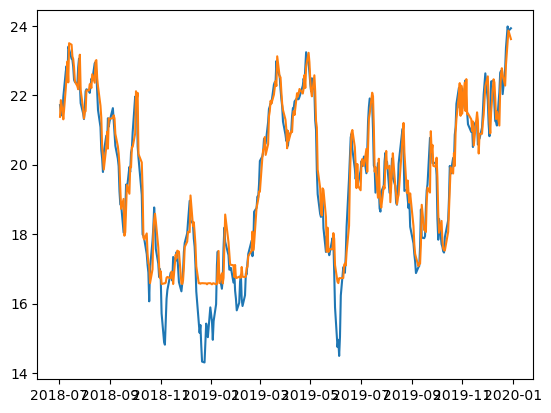

In [216]:
plt.plot(y_test_ma)
plt.plot(final_prediction)

In [224]:
overall_sharpe_sentiment_precentiles(final_prediction)[0]

NameError: name 'overall_sharpe_sentiment_precentiles' is not defined

In [225]:
overall_sharpe_sentiment_prec_exp(final_prediction)[0]

0.08584025473028456

In [226]:
portfolio_df_sent_test['trading day'].sum()

45

In [227]:
# Define the parameter grid
gb_param_grid = {
    'n_estimators': [25, 75, 175, 200],
    'max_depth': [1, 3, 5],
    'min_samples_leaf': [1, 5, 6],
    'learning_rate': np.linspace(0.01, 0.15,15)
}

# Setup the grid search
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train_ma, y_train_ma)

# Best model
gb_best_model = gb_grid_search.best_estimator_
print("Best parameters:", gb_grid_search.best_params_)
pred = gb_best_model.predict(X_test_ma)
print(r2_score(y_test_ma, pred))

pred = pd.Series(pred)
pred.index = y_test_ma.index
final_prediction_gb = pred[~pred.index.isin(pred.index.difference(portfolio_df_sent.index))]

Best parameters: {'learning_rate': 0.08999999999999998, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 175}
0.9206879940785307


In [228]:
overall_sharpe_sentiment_calc(final_prediction_gb)

0.1195750161278043

In [240]:
overall_sharpe_sentiment_precentiles(final_prediction_gb)[0]

0.06997239526516837

In [229]:
overall_sharpe_sentiment_prec_exp(final_prediction_gb)[0]

0.08559143654415355

<BarContainer object of 4 artists>

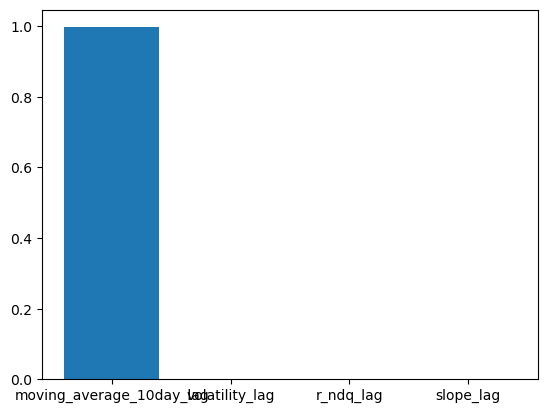

In [230]:
plt.bar(X_train_ma.columns, gb_best_model.feature_importances_)

Text(0.5, 1.0, 'Market regime classification \n 10 day moving average of sentiment index')

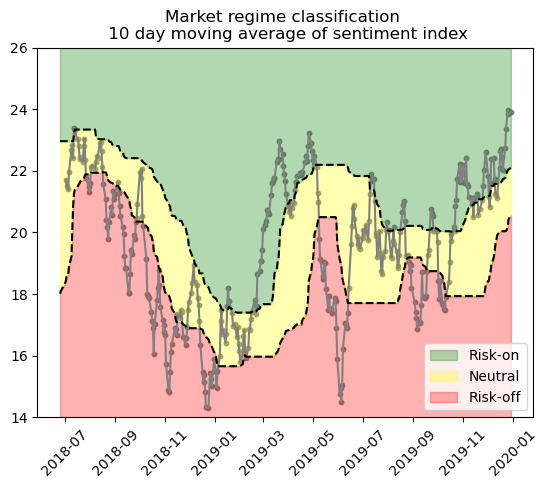

In [231]:
plt.plot(portfolio_df_sent_test['moving_average_10day'], color = 'gray')
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['moving_average_10day'], color = 'gray', s = 10)
plt.plot(portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), color = 'black', linestyle='--')
plt.plot(portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25),color = 'black', linestyle='--')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), y2 = 28, alpha = 0.3, color = 'green', label='Risk-on')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25), y2 =portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.75), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2018-04-01':].index, y1 = 12.5, y2 = portfolio_df_sent['2018-04-01':]['moving_average_10day'].rolling(60).quantile(0.25), alpha = 0.3, color = 'red', label='Risk-off')
plt.ylim(14, 26)
plt.xticks(rotation=45) 
plt.legend(loc='lower right')
plt.title('Market regime classification \n 10 day moving average of sentiment index')
#plt.text(18075, 13, 'Risk-off', backgroundcolor = 'red')
#plt.text(18075, 19, 'Neutral', backgroundcolor = 'yellow')
#plt.text(18075, 23, 'Risk-on', backgroundcolor = 'green')

In [670]:
pred_series = portfolio_df_sent['2018-03-01':'2019-01-01']['moving_average_10day'].append(final_prediction)

In [620]:
pred_series

Date
2018-10-01    21.957302
2018-10-02    21.772642
2018-10-03    22.051755
2018-10-04    20.527079
2018-10-05    20.201228
                ...    
2019-12-23    22.001957
2019-12-24    22.782137
2019-12-26    23.484841
2019-12-27    23.825003
2019-12-30    23.729504
Length: 310, dtype: float64

In [615]:
final_prediction

Date
2019-01-02    15.672098
2019-01-03    15.429694
2019-01-04    15.112405
2019-01-07    15.429694
2019-01-08    16.460352
                ...    
2019-12-23    22.001957
2019-12-24    22.782137
2019-12-26    23.484841
2019-12-27    23.825003
2019-12-30    23.729504
Length: 249, dtype: float64

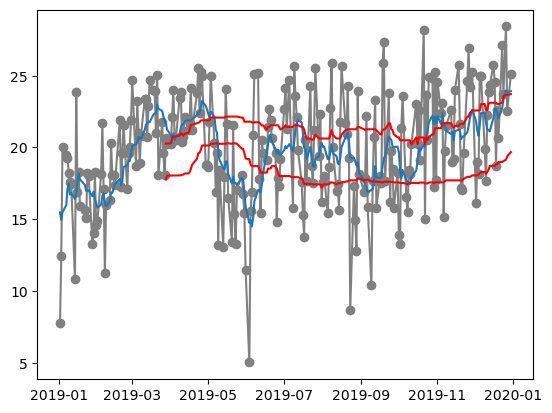

In [529]:
plt.plot(portfolio_df_sent_test['sentiment_score'], color = 'gray')
plt.plot(portfolio_df_sent_test['moving_average_10day'])
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['sentiment_score'], color = 'gray')
plt.plot(portfolio_df_sent_test['sentiment_score'].rolling(60).quantile(0.66), color = 'red')
plt.plot(portfolio_df_sent_test['sentiment_score'].rolling(60).quantile(0.33),color = 'red')

In [237]:
sharpe, lower, upper = overall_sharpe_sentiment_precentiles(portfolio_df_sent_test['sentiment_score'])

In [238]:
sharpe

0.37023385681236437

In [762]:
#price_df.set_index('Date', inplace=True)

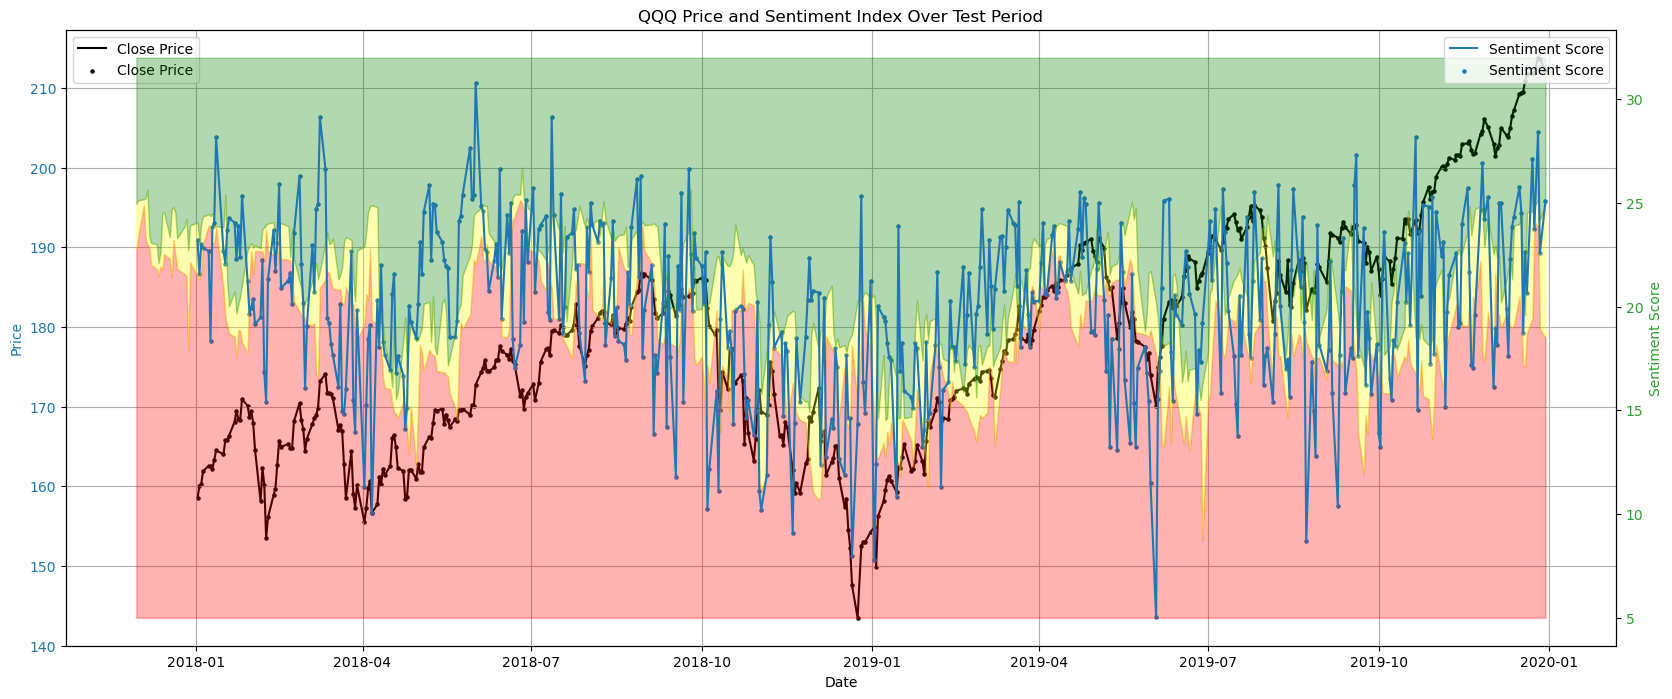

In [232]:
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plotting the price data on the first y-axis
ax1.set_xlabel('Date')  # Set the x-axis label
ax1.set_ylabel('Price', color='tab:blue')  # Set the y-axis label and color for the price data
#ax1.plot(price_df['Open']['2019-01-01':], color='tab:blue', label='Open Price')  # Plot the open prices
ax1.plot(price_df['Close']['2018-01-01':], color='black', label='Close Price')  # Plot the close prices
ax1.scatter(price_df['Close']['2018-01-01':].index, price_df['Close']['2018-01-01':], s=5, color='black', label='Close Price')  # Plot the close prices
ax1.tick_params(axis='y', labelcolor='tab:blue')  # Set the tick color for the y-axis
ax1.legend(loc='upper left')  # Place a legend in the upper left corner
ax1.grid(True)  # Enable grid
ax1.set_title('QQQ Price and Sentiment Index Over Test Period')  # Set title for the plot

# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sentiment Score', color='tab:green')  # Set the y-axis label and color for the sentiment data
ax2.plot(portfolio_df_sent['sentiment_score']['2018-01-01':], color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.scatter(portfolio_df_sent['sentiment_score']['2018-01-01':].index, portfolio_df_sent['sentiment_score']['2018-01-01':], s=5, color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.tick_params(axis='y', labelcolor='tab:green')  # Set the tick color for the y-axis
ax2.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = 5, y2 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), y2 =portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2017-11-01':].index, y1 = portfolio_df_sent['2017-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), y2 = 32, alpha = 0.3, color = 'green', label='Risk-on')

# Show the plot
plt.show()

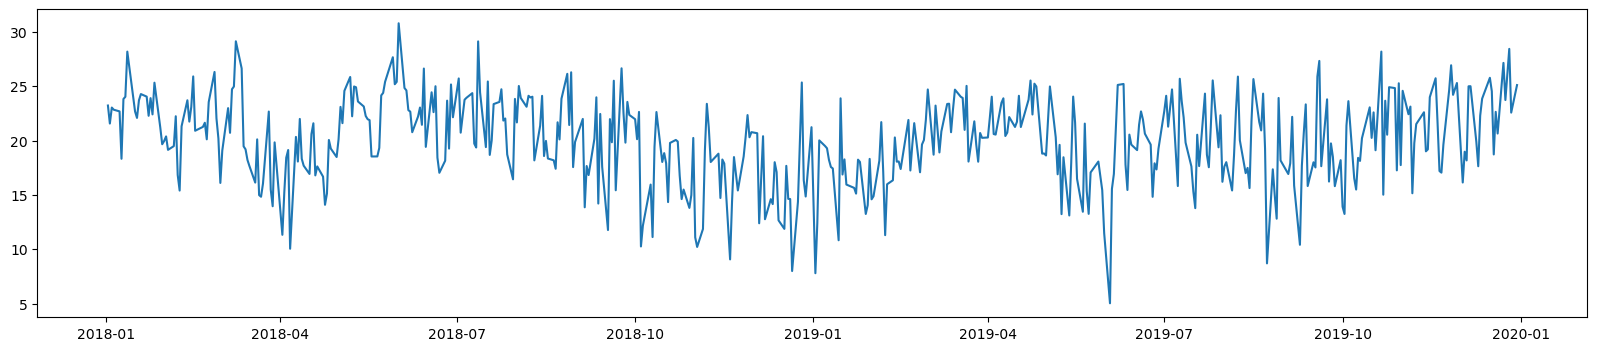

In [759]:
plt.figure(figsize = (20,4))
plt.plot(portfolio_df_sent_test['sentiment_score'])
plt.plot()

In [236]:
overall_sharpe_sentiment_precentiles(portfolio_df_sent_test['moving_average_10day'])[0]

0.12188948614884848

In [77]:
portfolio_df_sent_rolling = portfolio_df_sent['moving_average_10day']['2017-10-01':]

In [752]:
portfolio_df_sent_test

,r_ndq,r_rf,Volatility,rf_rate,sentiment_score,sentiment_slope,lag_sentiment,moving_average_10day
Date,,,,,,,,
2018-01-02,0.017527,-0.003315,11.00,0.000057,23.218681,0.639306,22.636305,20.565419
2018-01-03,0.009716,0.001046,10.25,0.000056,21.562063,1.396310,23.218681,19.783021
2018-01-04,0.001750,-0.000475,11.85,0.000056,23.031314,0.990790,21.562063,20.162382
2018-01-05,0.010043,-0.001235,11.94,0.000055,22.833049,2.735471,23.031314,20.314249
2018-01-08,0.003891,-0.000475,11.97,0.000058,22.679455,-0.574055,22.594403,20.855645
...,...,...,...,...,...,...,...,...
2019-12-23,0.002641,-0.000906,12.34,0.000063,27.140579,-0.659049,20.300683,22.753680
2019-12-24,0.000519,0.001724,12.36,0.000063,23.723393,-2.178170,27.140579,23.362800
2019-12-26,0.008824,0.001450,12.58,0.000063,28.429432,1.745469,21.436675,23.977012


In [233]:
def overall_sharpe_sentiment_precentiles(sentiment):
    w_ndq = []
    w_rf = []

    upper = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.75)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.25)
    #test_sent = sentiment['2018-01-01':]
    for i in sentiment.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [234]:
sharpe, upper, lower = overall_sharpe_sentiment_precentiles(final_prediction)

In [235]:
sharpe

0.08628409436264409

In [727]:
sharpe2, upper2, lower2 = overall_sharpe_sentiment_precentiles(pred_series)

In [728]:
sharpe2

0.15294778547888946

In [722]:
sharpe3, upper3, lower3 = overall_sharpe_sentiment_precentiles(portfolio_df_sent['sentiment_score']['2018-05-01':])

In [723]:
sharpe3

0.4090602400107156

In [625]:
sharpe

0.13648397063874276

In [624]:
sharpe2

0.13147713123253804

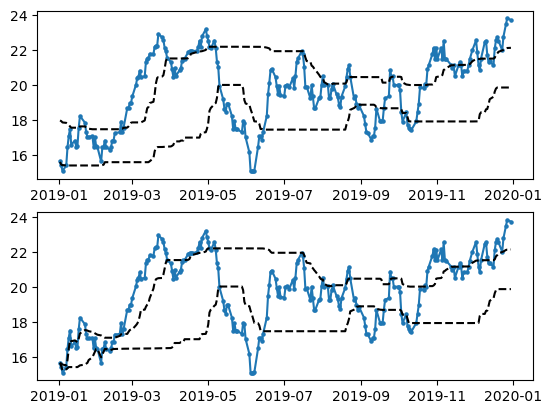

In [631]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(final_prediction)
plt.scatter(final_prediction.index, final_prediction, s = 5)
plt.plot(upper2['2019-01-01':], color = 'black', linestyle = '--')
plt.plot(lower2['2019-01-01':], color = 'black', linestyle = '--')
#plt.subplot(2,2,2)
#plt.plot(portfolio_df_sent_test['w_ndq'])

plt.subplot(2,1,2)
plt.plot(final_prediction)
plt.scatter(final_prediction.index, final_prediction, s = 5)
plt.plot(final_prediction.index, upper, color = 'black', linestyle = '--')
plt.plot(final_prediction.index, lower, color = 'black', linestyle = '--')
#plt.subplot(2,2,4)
#plt.plot(portfolio_df_sent_test['w_ndq'])
plt.show()

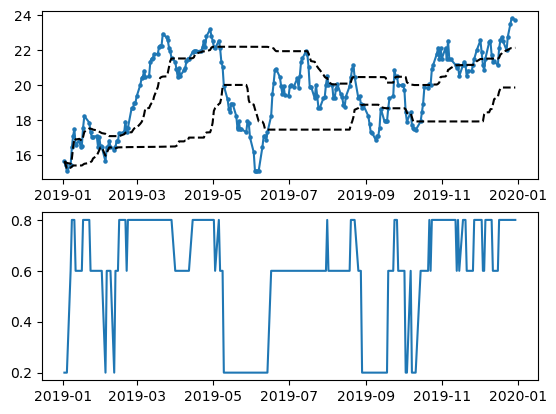

In [613]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(final_prediction)
plt.scatter(final_prediction.index, final_prediction, s = 5)
plt.plot(final_prediction.index, upper, color = 'black', linestyle = '--')
plt.plot(final_prediction.index, lower, color = 'black', linestyle = '--')
plt.subplot(2,1,2)
plt.plot(portfolio_df_sent_test['w_ndq'])
plt.show()

In [629]:
sharpe, sharpe2

(0.13648397063874276, 0.13147713123253804)

In [610]:
portfolio_df_sent_test['trading day'].sum()

44

In [634]:
ma_data = portfolio_df_sent['2018-10-01':'2019-01-01']['moving_average_10day'].append(portfolio_df_sent_test['moving_average_10day'])

In [639]:
sharpe, upper, lower = overall_sharpe_sentiment_precentiles(ma_data)

In [636]:
sharpe

0.19933460279186893

In [640]:
upper.shape

(310,)

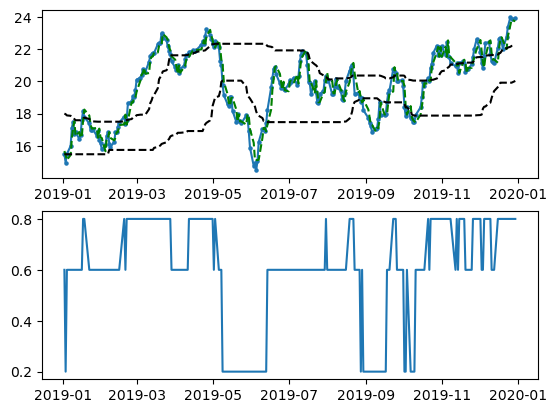

In [643]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(portfolio_df_sent_test['moving_average_10day'])
plt.scatter(portfolio_df_sent_test.index, portfolio_df_sent_test['moving_average_10day'], s = 5)
plt.plot(final_prediction, color = 'green', linestyle = '--')
plt.plot(portfolio_df_sent_test.index, upper['2019-01-01':], color = 'black', linestyle = '--')
plt.plot(portfolio_df_sent_test.index, lower['2019-01-01':], color = 'black', linestyle = '--')
plt.subplot(2,1,2)
plt.plot(portfolio_df_sent_test['w_ndq'])
plt.show()

In [644]:
overall_sharpe_sentiment_precentiles(portfolio_df_sent['sentiment_score'])

(0.39713324214350637,
 Date
 2015-01-05    17.779190
 2015-01-06    17.702248
 2015-01-07    18.260302
 2015-01-08    19.823184
 2015-01-09    19.972191
                 ...    
 2019-12-23    24.587818
 2019-12-24    24.587818
 2019-12-26    24.685020
 2019-12-27    24.685020
 2019-12-30    24.839692
 Name: sentiment_score, Length: 1247, dtype: float64,
 Date
 2015-01-05    17.779190
 2015-01-06    17.471422
 2015-01-07    17.548364
 2015-01-08    17.625306
 2015-01-09    17.702248
                 ...    
 2019-12-23    17.716393
 2019-12-24    17.716393
 2019-12-26    18.045541
 2019-12-27    18.045541
 2019-12-30    18.159355
 Name: sentiment_score, Length: 1247, dtype: float64)

----------------------------------------------
rolling window with exponentially decaying weights:

In [672]:
# Define the window size and alpha for exponential decay
window_size = 60
alpha = 0.5

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])

# Normalize weights
weights /= weights.sum()

# Define the custom function to apply
def weighted_avg(values):
    return np.dot(values, weights)


In [294]:
# Define the window size and alpha for exponential decay
window_size = 60
alpha = 0.9

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])
weights = np.flip(weights)

# Normalize weights
weights /= weights.sum()

# Define the custom function to calculate quantiles with weights
def weighted_quantile(values, quantile=0.5):
    # Ensure the values are sorted
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    # Compute the cumulative sum of weights
    cumsum = np.cumsum(weights_sorted)

    # Find where the cumulative sum equals or exceeds the quantile
    return np.interp(quantile, cumsum, values_sorted)

In [248]:
portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True).dropna()

Date
2017-12-28    23.620690
2017-12-29    23.190788
2018-01-02    23.155518
2018-01-03    22.535509
2018-01-04    22.213826
                ...    
2019-12-23    22.464596
2019-12-24    22.699765
2019-12-26    22.753680
2019-12-27    23.362800
2019-12-30    23.727263
Name: moving_average_10day, Length: 500, dtype: float64

In [295]:

def overall_sharpe_sentiment_prec_exp(sentiment):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    upper = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.75), raw=True)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60).apply(lambda x: weighted_quantile(x, quantile=0.25), raw=True)
    test_sent = sentiment['2018-07-01':]
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [344]:
overall_sharpe_sentiment_precentiles(final_prediction_gb)[0]

0.06997239526516837

In [345]:
overall_sharpe_sentiment_prec_exp(final_prediction_gb)[0]

0.05603065199266541

--------------------------
optimizing precentiles:


Think it's not a great idea, gives worse results for test data!

In [694]:
def sharpe_precentiles(r,s, portfolio_df_sent_train = portfolio_df_sent_train):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    portfolio_df_sent_train['upper'] = portfolio_df_sent_train['moving_average_10day'].rolling(60).apply(lambda x: weighted_quantile(x, quantile=s/100), raw=True)
    portfolio_df_sent_train['lower'] = portfolio_df_sent_train['moving_average_10day'].rolling(60).apply(lambda x: weighted_quantile(x, quantile=r/100), raw=True)
    portfolio_df_sent_train = portfolio_df_sent_train.dropna()
    for i in portfolio_df_sent_train.index:
        score = portfolio_df_sent_train['moving_average_10day'][i]
        if score > portfolio_df_sent_train['upper'][i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= portfolio_df_sent_train['upper'][i] and score > portfolio_df_sent_train['lower'][i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= portfolio_df_sent_train['lower'][i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_train['w_ndq'] = w_ndq
    portfolio_df_sent_train['w_rf'] = w_rf
    portfolio_df_sent_train['r_portfolio'] = portfolio_df_sent_train['w_ndq'] * portfolio_df_sent_train['r_ndq'] + portfolio_df_sent_train['w_rf'] * portfolio_df_sent_train['r_rf']
    portfolio_df_sent_train['excess returns'] = portfolio_df_sent_train['r_portfolio'] - portfolio_df_sent_train['rf_rate']
    portfolio_df_sent_train['trading day'] = (portfolio_df_sent_train['w_ndq'] != portfolio_df_sent_train['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_train['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_train['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_train['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio

In [696]:
from itertools import product
# Define ranges for r and s
r_values = np.linspace(15, 45, 31)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(55, 90, 36)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    #print('first loop', r, s)
    if s > r:  # Ensure s is always greater than r
        sharpe = sharpe_precentiles(r, s)
        #print(sharpe)
        if sharpe > max_sharpe:
            #print(r, s)
            max_sharpe = sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Overall Sharpe: {max_sharpe}')

Best r: 23.0, Best s: 89.0, Maximized Overall Sharpe: 0.09925883710961116


--------------------------------------------------------

Classification model: